# 🚀 Barrier Reef YOLOX [Inference]

### Hi kagglers, This is `Inference` notebook using `YOLOX`.


### Other notebooks in the competition
- [Barrier Reef YOLOX [Training]](https://www.kaggle.com/ammarnassanalhajali/barrier-reef-yolox-training)



### Please if this kernel is useful, <font color='red'>please upvote !!</font>

# ☀️ Importing Libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import os
import torch
import importlib
import cv2 
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
from PIL import Image
from IPython.display import display

# ⬇️ Install YOLOX


In [ ]:
%cp -r /kaggle/input/yolox-cots-models /kaggle/working/
%cd /kaggle/working/yolox-cots-models/yolox-dep

#%cp -r /kaggle/input/barrier-reef-yolox/best_ckpt.pth /kaggle/working/yolox-cots-models

### Install YOLOX required modules

In [ ]:
!pip install pip-21.3.1-py3-none-any.whl -f ./ --no-index
!pip install loguru-0.5.3-py3-none-any.whl -f ./ --no-index
!pip install ninja-1.10.2.3-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl -f ./ --no-index
!pip install onnx-1.8.1-cp37-cp37m-manylinux2010_x86_64.whl -f ./ --no-index
!pip install onnxruntime-1.8.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl -f ./ --no-index
!pip install onnxoptimizer-0.2.6-cp37-cp37m-manylinux2014_x86_64.whl -f ./ --no-index
!pip install thop-0.0.31.post2005241907-py3-none-any.whl -f ./ --no-index
!pip install tabulate-0.8.9-py3-none-any.whl -f ./ --no-index

In [ ]:
%cd /kaggle/working/yolox-cots-models/YOLOX
!pip install -r requirements.txt
!pip install -v -e . 

### Install CocoAPI tool

In [ ]:
%cd /kaggle/working/yolox-cots-models/yolox-dep/cocoapi/PythonAPI

!make
!make install
!python setup.py install

import pycocotools

# 🔨 Functions

In [ ]:
def yolox_inference(img, model, test_size): 
    bboxes = []
    bbclasses = []
    scores = []
    
    preproc = ValTransform(legacy = False)

    tensor_img, _ = preproc(img, None, test_size)
    tensor_img = torch.from_numpy(tensor_img).unsqueeze(0)
    tensor_img = tensor_img.float()
    tensor_img = tensor_img.cuda()

    with torch.no_grad():
        outputs = model(tensor_img)
        outputs = postprocess(
                    outputs, num_classes, confthre,
                    nmsthre, class_agnostic=True
                )

    if outputs[0] is None:
        return [], [], []
    
    outputs = outputs[0].cpu()
    bboxes = outputs[:, 0:4]

    bboxes /= min(test_size[0] / img.shape[0], test_size[1] / img.shape[1])
    bbclasses = outputs[:, 6]
    scores = outputs[:, 4] * outputs[:, 5]
    
    return bboxes, bbclasses, scores

In [ ]:
def draw_yolox_predictions(img, bboxes, scores, bbclasses, confthre, classes_dict):
    for i in range(len(bboxes)):
            box = bboxes[i]
            cls_id = int(bbclasses[i])
            score = scores[i]
            if score < confthre:
                continue
            x0 = int(box[0])
            y0 = int(box[1])
            x1 = int(box[2])
            y1 = int(box[3])
            
            cv2.rectangle(img, (x0, y0), (x1, y1), (255, 0, 255), 1)
            cv2.putText(img, '{}:{:.1f}%'.format(classes_dict[cls_id], score * 100), (x0, y0 - 1), cv2.FONT_HERSHEY_SIMPLEX, 0.6,(255,0,255), thickness = 2)
    return img

In [ ]:
def format_prediction(bboxes, confs,confthre):
    annot = ''
    if len(bboxes)>0:
        for idx in range(len(bboxes)):
            box = bboxes[idx]
            x_min = int(box[0])
            y_min = int(box[1])
            x_max = int(box[2])
            y_max = int(box[3])

            w=x_max-x_min
            h=y_max-y_min
            
            conf = confs[idx]
            if conf < confthre:
                continue
            annot += '{:.3f} {} {} {} {}'.format(conf, x_min, y_min, w, h)
            annot +=' '
        annot = annot.strip(' ')
    return annot

# Preparing  The Model

In [ ]:
%cd /kaggle/working/yolox-cots-models/YOLOX
CHECKPOINT_FILE = '/kaggle/working/yolox-cots-models/yx_l_003.pth'

In [ ]:
config_file_template = '''

#!/usr/bin/env python3
# -*- coding:utf-8 -*-
# Copyright (c) Megvii, Inc. and its affiliates.

import os

from yolox.exp import Exp as MyExp


class Exp(MyExp):
    def __init__(self):
        super(Exp, self).__init__()
        self.depth = 1
        self.width = 1
        self.exp_name = os.path.split(os.path.realpath(__file__))[1].split(".")[0]
        self.num_classes = 1

'''

with open('cots_config.py', 'w') as f:
    f.write(config_file_template)

In [ ]:
from yolox.utils import postprocess
from yolox.data.data_augment import ValTransform

COCO_CLASSES = (
  "starfish",
)

# get YOLOX experiment
current_exp = importlib.import_module('cots_config')
exp = current_exp.Exp()

# set inference parameters
test_size = (800, 1280)
num_classes = 1
confthre = 0.09
nmsthre = 0.41


# get YOLOX model
model = exp.get_model()
model.cuda()
model.eval()

# get custom trained checkpoint
ckpt_file = CHECKPOINT_FILE
ckpt = torch.load(ckpt_file, map_location="cpu")
model.load_state_dict(ckpt["model"])

# Inference on a image from the Validation set

In [ ]:
TEST_IMAGE_PATH = "/kaggle/input/tensorflow-great-barrier-reef/train_images/video_2/5745.jpg"
img = cv2.imread(TEST_IMAGE_PATH)

# Get predictions
bboxes, bbclasses, scores = yolox_inference(img, model, test_size)

# Draw predictions
out_image = draw_yolox_predictions(img, bboxes, scores, bbclasses, confthre, COCO_CLASSES)

# Since we load image using OpenCV we have to convert it 
out_image = cv2.cvtColor(out_image, cv2.COLOR_BGR2RGB)
display(Image.fromarray(out_image))

#  Inference

In [ ]:
%cd /kaggle/working/

In [ ]:
import greatbarrierreef
env = greatbarrierreef.make_env()# initialize the environment
iter_test = env.iter_test()      # an iterator which loops over the test set and sample submission

In [ ]:
for idx, (img, pred_df) in enumerate(tqdm(iter_test)):
    bboxes, bbclasses, scores = yolox_inference(img[:,:,::-1], model, test_size)
    annot = format_prediction(bboxes, scores,confthre)
    pred_df['annotations'] = annot
    env.predict(pred_df)
    if idx<3:
        out_image = draw_yolox_predictions(img, bboxes, scores, bbclasses, confthre, COCO_CLASSES)
        display(Image.fromarray(out_image))    

In [ ]:
sub_df = pd.read_csv('submission.csv')
sub_df.head()

### Please if this kernel is useful, <font color='red'>please upvote !!</font>

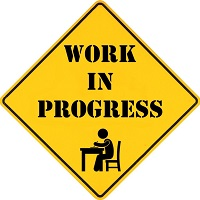

# References

1. https://www.kaggle.com/remekkinas/yolox-inference-on-kaggle-for-cots-lb-0-507
1. https://www.kaggle.com/awsaf49/great-barrier-reef-yolov5-infer
